In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
# general settings for signal and noise
sample_freq = 1e5  # in Hz
length = 15.0  # in s
noise_power = 5.0  # in dB

# create 'DopplerSignal' object
ds = ss.DopplerSignal(
    t_sec=length,  # length of signal in seconds
    f_sample=sample_freq,  # sample frequency after decimation
    f_carrier=450e6,  # frequency of signal before down sapling to baseband
    steps=int(1e3))  # steps / resolution

# get frequency and power vectors that contain the doppler shift
t, freq, signal_power = ds.get(
    f_center=-1e4,  # center frequency at half way point in Hz
    power=0.,  # power at half way point in dB ('peak' power)
    distance=6000.0,  # distance in m
    velocity=8000.0)  # velocity in m/s

# create the signal (the 'very_silent' kind) using the doppler shift vectors
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.very_silent(f_center=freq, power=signal_power, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: -5.33 dB
Noise power:  5.00 dB
SNR:          -10.33 dB
Num samples:  1500000


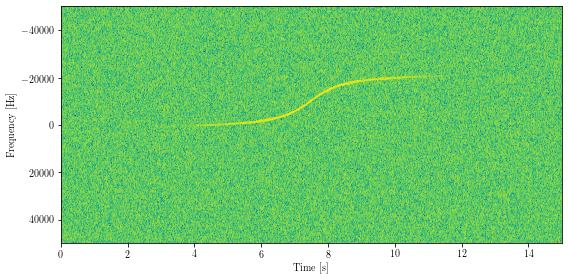

In [4]:
plt.figure(figsize=(8, 4))
sft = ss.Stft(n=512, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)
plt.pcolormesh(t,
               f,
               x,
               cmap='viridis',
               vmin=np.min(x),
               vmax=np.max(x))
plt.xlabel(r'Time [s]')
plt.ylabel(r'Frequency [Hz]')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('out/chap4/doppler.png', dpi=1200)